## Aim of the following notebook is to obtain further insights into the correlation between the local atomic environment of an Fe atom and its Orbital Moment Anisotropy (OMA) in L10 FeNi using Unsupervised machine learning methods.  

Author: Ankit Izardar

### Note: This notebook is a part of the research article "Effect of chemical disorder on the magnetic anisotropy in L10 FeNi from first principles calculations". For further explanation of the plots below, please refer to the original article.

### We define the Orbital Moment Anisotropy (OMA) = $L_{[001]} - L_{[100]}$, where $L_{[001]}$ and $L_{[100]}$ are the total orbital moments when the magnetization lies along the $[001]$ and $[100]$ directions, respectively. 

In [1]:
# Import necessary libraries

%matplotlib notebook
from IPython.display import Image
from IPython.core.display import HTML 


get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import glob
import pandas as pd
import numpy as np
np.random.seed(7) 

from ase.build import bulk
from dscribe.descriptors import SOAP
from ase.io import read, write
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from sklearn.manifold import TSNE



### Read all structure files (POSCAR)
#### Note: For each order parameter ($P_z$), we create 50 different configurations where each configuration is a 2x2x2 supercell of the conventional cubic cell containing 16 Fe and 16 Ni atoms

![](supercells.png)

In [2]:
PATH_0 = 'POSCARS/Pz_0/*'
PATH_0p25 = 'POSCARS/Pz_0p25/*'
PATH_0p5 = 'POSCARS/Pz_0p5/*'
PATH_0p75 = 'POSCARS/Pz_0p75/*'
PATH_Ordered = 'POSCARS/Ordered/POSCAR'

### Read Orbital moment anisotropies of atoms belonging to different structures

In [3]:
OMA_0 = pd.read_csv('POSCARS/Pz_0/OMMA_Pz_0_with_Elem.txt', sep = '\t')
OMA_0p25 = pd.read_csv('POSCARS/Pz_0p25/OMMA_Pz_0p25_with_Elem.txt', sep = '\t')
OMA_0p5 = pd.read_csv('POSCARS/Pz_0p5/OMMA_Pz_0p5_with_Elem.txt', sep = '\t')
OMA_0p75 = pd.read_csv('POSCARS/Pz_0p75/OMMA_Pz_0p75_with_Elem.txt', sep = '\t')
OMA_1 = pd.read_csv('POSCARS/Ordered/OMMA_Pz_1_with_Elem.txt', sep = '\t')

OMA_last_two = pd.concat([OMA_0p75, OMA_1], ignore_index = True)   

## Create SOAP descriptor

To obtain further insights into the correlation between the local atomic environment of an Fe atom and its OMA, it is desirable to have a more quantitative way, in the form of well-defined descriptors, to characterize the local atomic environments. For this purpose, we employ the smooth overlap of atomic positions (SOAP) [1] approach as implemented in the DScribe software package [2], which encodes the local atomic environment, up to  a specified cutoff distance, into a rotationally invariant rep-resentation, given by the “SOAP vectors”. The length of the vectors generated by SOAP depends, among other quantities, on the number of different chemical species. In our case, we generate SOAP vectors corresponding to local atomic environments including upto first nearest-neighbors (1NN, second nearest-neighbors (2NN), and third nearest-neighbors (3NN) only. In order to  visualize the correlation between the local atomic environment of the Fe atoms and their OMA, we reduce the high-dimensional SOAP vectors to two dimensions using the t-distributed stochastic neighbor embedding (t-SNE)technique [3] as implemented in scikit-learn.

1. Albert P. Bartók, Risi Kondor, and Gábor Csányi. On representing chemical environments. Physical Review B - Condensed Matter and Materials Physics, 87(18):1–16, 2013. doi:10.1103/PhysRevB.87.184115.
2. L. Himanen, M. O. Jager, E. V. Morooka, F. FedericiCanova, Y. S. Ranawat, D. Z. Gao, P. Rinke, and A. S.Foster, Computer Physics Communications247, 106949(2020).
3. L. van der Maaten and G. Hinton, Journal of Machine Learning Research9, 2579 (2008).

In [4]:
#For reference, following are cutoff distances for various nearest neighbours in an FCC structure. 

#rcut = 2.6  #1NN 
#rcut = 3.6  #2NN
#rcut = 4.4  #3NN
#rcut = 5.1  #4NN
#rcut = 5.7  #5NN
#rcut = 6.2  #6NN
#rcut = 6.7  #7NN
#rcut = 7.2  #8NN
#rcut = 7.6  #9NN
#rcut = 8.0  #10NN



def get_SOAP_descriptor_rcut(rcut):
    """
    Returns pandas dataframes (X's and Y's) where each row in X is a soap vector for an Fe atom and its corresponding value of OMA in a row in Y. 
    param rcut : A cutoff for local region in angstroms
    """
    
    # Setting up the SOAP descriptor
    # Check out this link (https://singroup.github.io/dscribe/latest/tutorials/descriptors/soap.html) for more information on the parameters below

    periodic_soap = SOAP(
    species=['Fe', 'Ni'],
    rcut=rcut,
    nmax=8,
    lmax=6,
    periodic=True,
    sparse=False, 
    rbf = 'polynomial',
    sigma = 0.5)

    
    def soap_descriptor(PATH):
        """ 
        Returns a list of SOAP descriptors for all selected structures POSCARS
        param PATH: Path for structure files
        """
        
        
        # Read directories containing structure files in ascending order
        # Note: Directories are names 1, 2, 3, and so on...

        all_files = glob.glob(PATH + '/POSCAR')
        temp = all_files[1]
        indexes = [int(temp.split(sep="/")[-2]) for temp in all_files]
        order = np.argsort(indexes)
        list_soap = []

        for file in order:
            structure = read(all_files[file])
            soap_descriptor = periodic_soap.create(structure)
            list_soap.append(soap_descriptor)
        return list_soap



    def reshape_soap_descriptor(soap_FeNi):
        """
        Reshape list of SOAP descriptors from (a,b,c) --> (a*b, c) 
        param soap_FeNi : a list of SOAP descriptors
        Returns list of soap descriptors in the form of a pandas dataframe
        """
        X = np.reshape(soap_FeNi, (soap_FeNi.shape[0]* soap_FeNi.shape[1],soap_FeNi.shape[2]))

        df_X = pd.DataFrame(X)
        df_X = df_X.round(4)
        return df_X


    def process_X_Y(df_X, df_Y):
        """
        Process X and Y dataframe to include unique descriptors for Fe atoms only.
        param df_X: dataframe containing soap vectors for atoms 
        param df_Y: dataframe containing OMA values of atoms 
        """

        X = []
        Y = []

        df = pd.concat([df_X, df_Y], axis = 1)

        df_Fe = df[df.Elements == 'Fe'] # Drop all Ni atoms 

        df_Fe = df_Fe.drop(['Elements', 'OMM_X','OMM_Z'], axis = 1) # Drop Elements column
        #print("\nNumber of original rows = ", len(df_Fe))

        if np.any(df_Fe.duplicated()):
            print("\nIdentical rows found!\nRemoving rows\n")


        df_Fe.drop_duplicates(keep = 'first', inplace = True) # Drop identical rows
        #print("\nNumber of rows after removing identical data = ", len(df_Fe))

        Y = df_Fe[["Z_subtract_X"]]  
        Y = np.array(Y)
        X = df_Fe.drop(["Z_subtract_X"], axis = 1)

        return X, Y



    # For ordered configuration (there is only 1)                              
    
    list_ordered = []
    ordered = read(PATH_Ordered)
    descriptor_ordered = periodic_soap.create(ordered)
    list_ordered.append(descriptor_ordered)

    # Create lists for all soap vectors
    
    list_0  = soap_descriptor(PATH_0)
    list_0p25  = soap_descriptor(PATH_0p25)
    list_0p5  = soap_descriptor(PATH_0p5)
    list_0p75  = soap_descriptor(PATH_0p75)
    list_last_two = list_0p75 + list_ordered

    # Convert to numpy array
    
    soap_FeNi_0 = np.array(list_0)
    #print(soap_FeNi_0.shape)
    soap_FeNi_0p25 = np.array(list_0p25)
    #print(soap_FeNi_0p25.shape)
    soap_FeNi_0p5 = np.array(list_0p5)
    #print(soap_FeNi_0p5.shape)
    soap_FeNi_last_two = np.array(list_last_two)
    #print(soap_FeNi_last_two.shape) 
    
    # Reshape SOAP vectors

    df_X_0 = reshape_soap_descriptor(soap_FeNi_0)
    df_X_0p25 = reshape_soap_descriptor(soap_FeNi_0p25)
    df_X_0p5 = reshape_soap_descriptor(soap_FeNi_0p5)
    df_X_last_two = reshape_soap_descriptor(soap_FeNi_last_two)

    # Process 
    
    X_0,Y_0 = process_X_Y(df_X_0, OMA_0)
    X_0p25,Y_0p25 = process_X_Y(df_X_0p25, OMA_0p25)
    X_0p5,Y_0p5 = process_X_Y(df_X_0p5, OMA_0p5)
    X_last_two,Y_last_two = process_X_Y(df_X_last_two, OMA_last_two)

    return X_0,Y_0, X_0p25,Y_0p25, X_0p5,Y_0p5, X_last_two,Y_last_two 

### Get SOAP vectors for 1NN, 2NN, and 3NN

In [5]:
# Rcut = 2.6 (First Nearest Neighbours)

X_0_1NN,Y_0_1NN,X_0p25_1NN,Y_0p25_1NN,X_0p5_1NN,Y_0p5_1NN,X_last_two_1NN,Y_last_two_1NN  = get_SOAP_descriptor_rcut(rcut = 2.6)

# Rcut = 3.6 (Second Nearest Neighbours)

X_0_2NN,Y_0_2NN,X_0p25_2NN,Y_0p25_2NN,X_0p5_2NN,Y_0p5_2NN,X_last_two_2NN,Y_last_two_2NN  = get_SOAP_descriptor_rcut(rcut = 3.6)

# Rcut = 4.4 (Third Nearest Neighbours)

X_0_3NN,Y_0_3NN,X_0p25_3NN,Y_0p25_3NN,X_0p5_3NN,Y_0p5_3NN,X_last_two_3NN,Y_last_two_3NN  = get_SOAP_descriptor_rcut(rcut = 4.4)


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows


Identical rows found!
Removing rows



## 1. T-SNE visualization
### To know more on how t-SNE algorithm works, please watch this (https://www.youtube.com/watch?v=RJVL80Gg3lA&t=761s&ab_channel=GoogleTechTalks) excellent talk by Laurens van der Maaten

In [6]:
def get_t_sne_reduced_X(X, per):
    
    return TSNE(n_components=2, perplexity=per, verbose=0, learning_rate = 300).fit_transform(X)

### Get t-SNE reduced SOAP vectors for 1NN, 2NN, and 3NN

In [7]:
per = 6

# First Nearest Neighbours

X_t_sne_Pz_0_1NN = get_t_sne_reduced_X(X_0_1NN, per)
X_t_sne_Pz_0p25_1NN  = get_t_sne_reduced_X(X_0p25_1NN, per)
X_t_sne_Pz_0p5_1NN = get_t_sne_reduced_X(X_0p5_1NN, per)
X_t_sne_Pz_0p75_and_1_1NN = get_t_sne_reduced_X(X_last_two_1NN, per)

# Second Nearest Neighbours

X_t_sne_Pz_0_2NN = get_t_sne_reduced_X(X_0_2NN, per)
X_t_sne_Pz_0p25_2NN  = get_t_sne_reduced_X(X_0p25_2NN, per)
X_t_sne_Pz_0p5_2NN = get_t_sne_reduced_X(X_0p5_2NN, per)
X_t_sne_Pz_0p75_and_1_2NN = get_t_sne_reduced_X(X_last_two_2NN, per)

# Third Nearest Neighbours

X_t_sne_Pz_0_3NN = get_t_sne_reduced_X(X_0_3NN, per)
X_t_sne_Pz_0p25_3NN  = get_t_sne_reduced_X(X_0p25_3NN,per)
X_t_sne_Pz_0p5_3NN = get_t_sne_reduced_X(X_0p5_3NN, per)
X_t_sne_Pz_0p75_and_1_3NN = get_t_sne_reduced_X(X_last_two_3NN, per)

### Plot the t-SNE visualization of the SOAP vectors

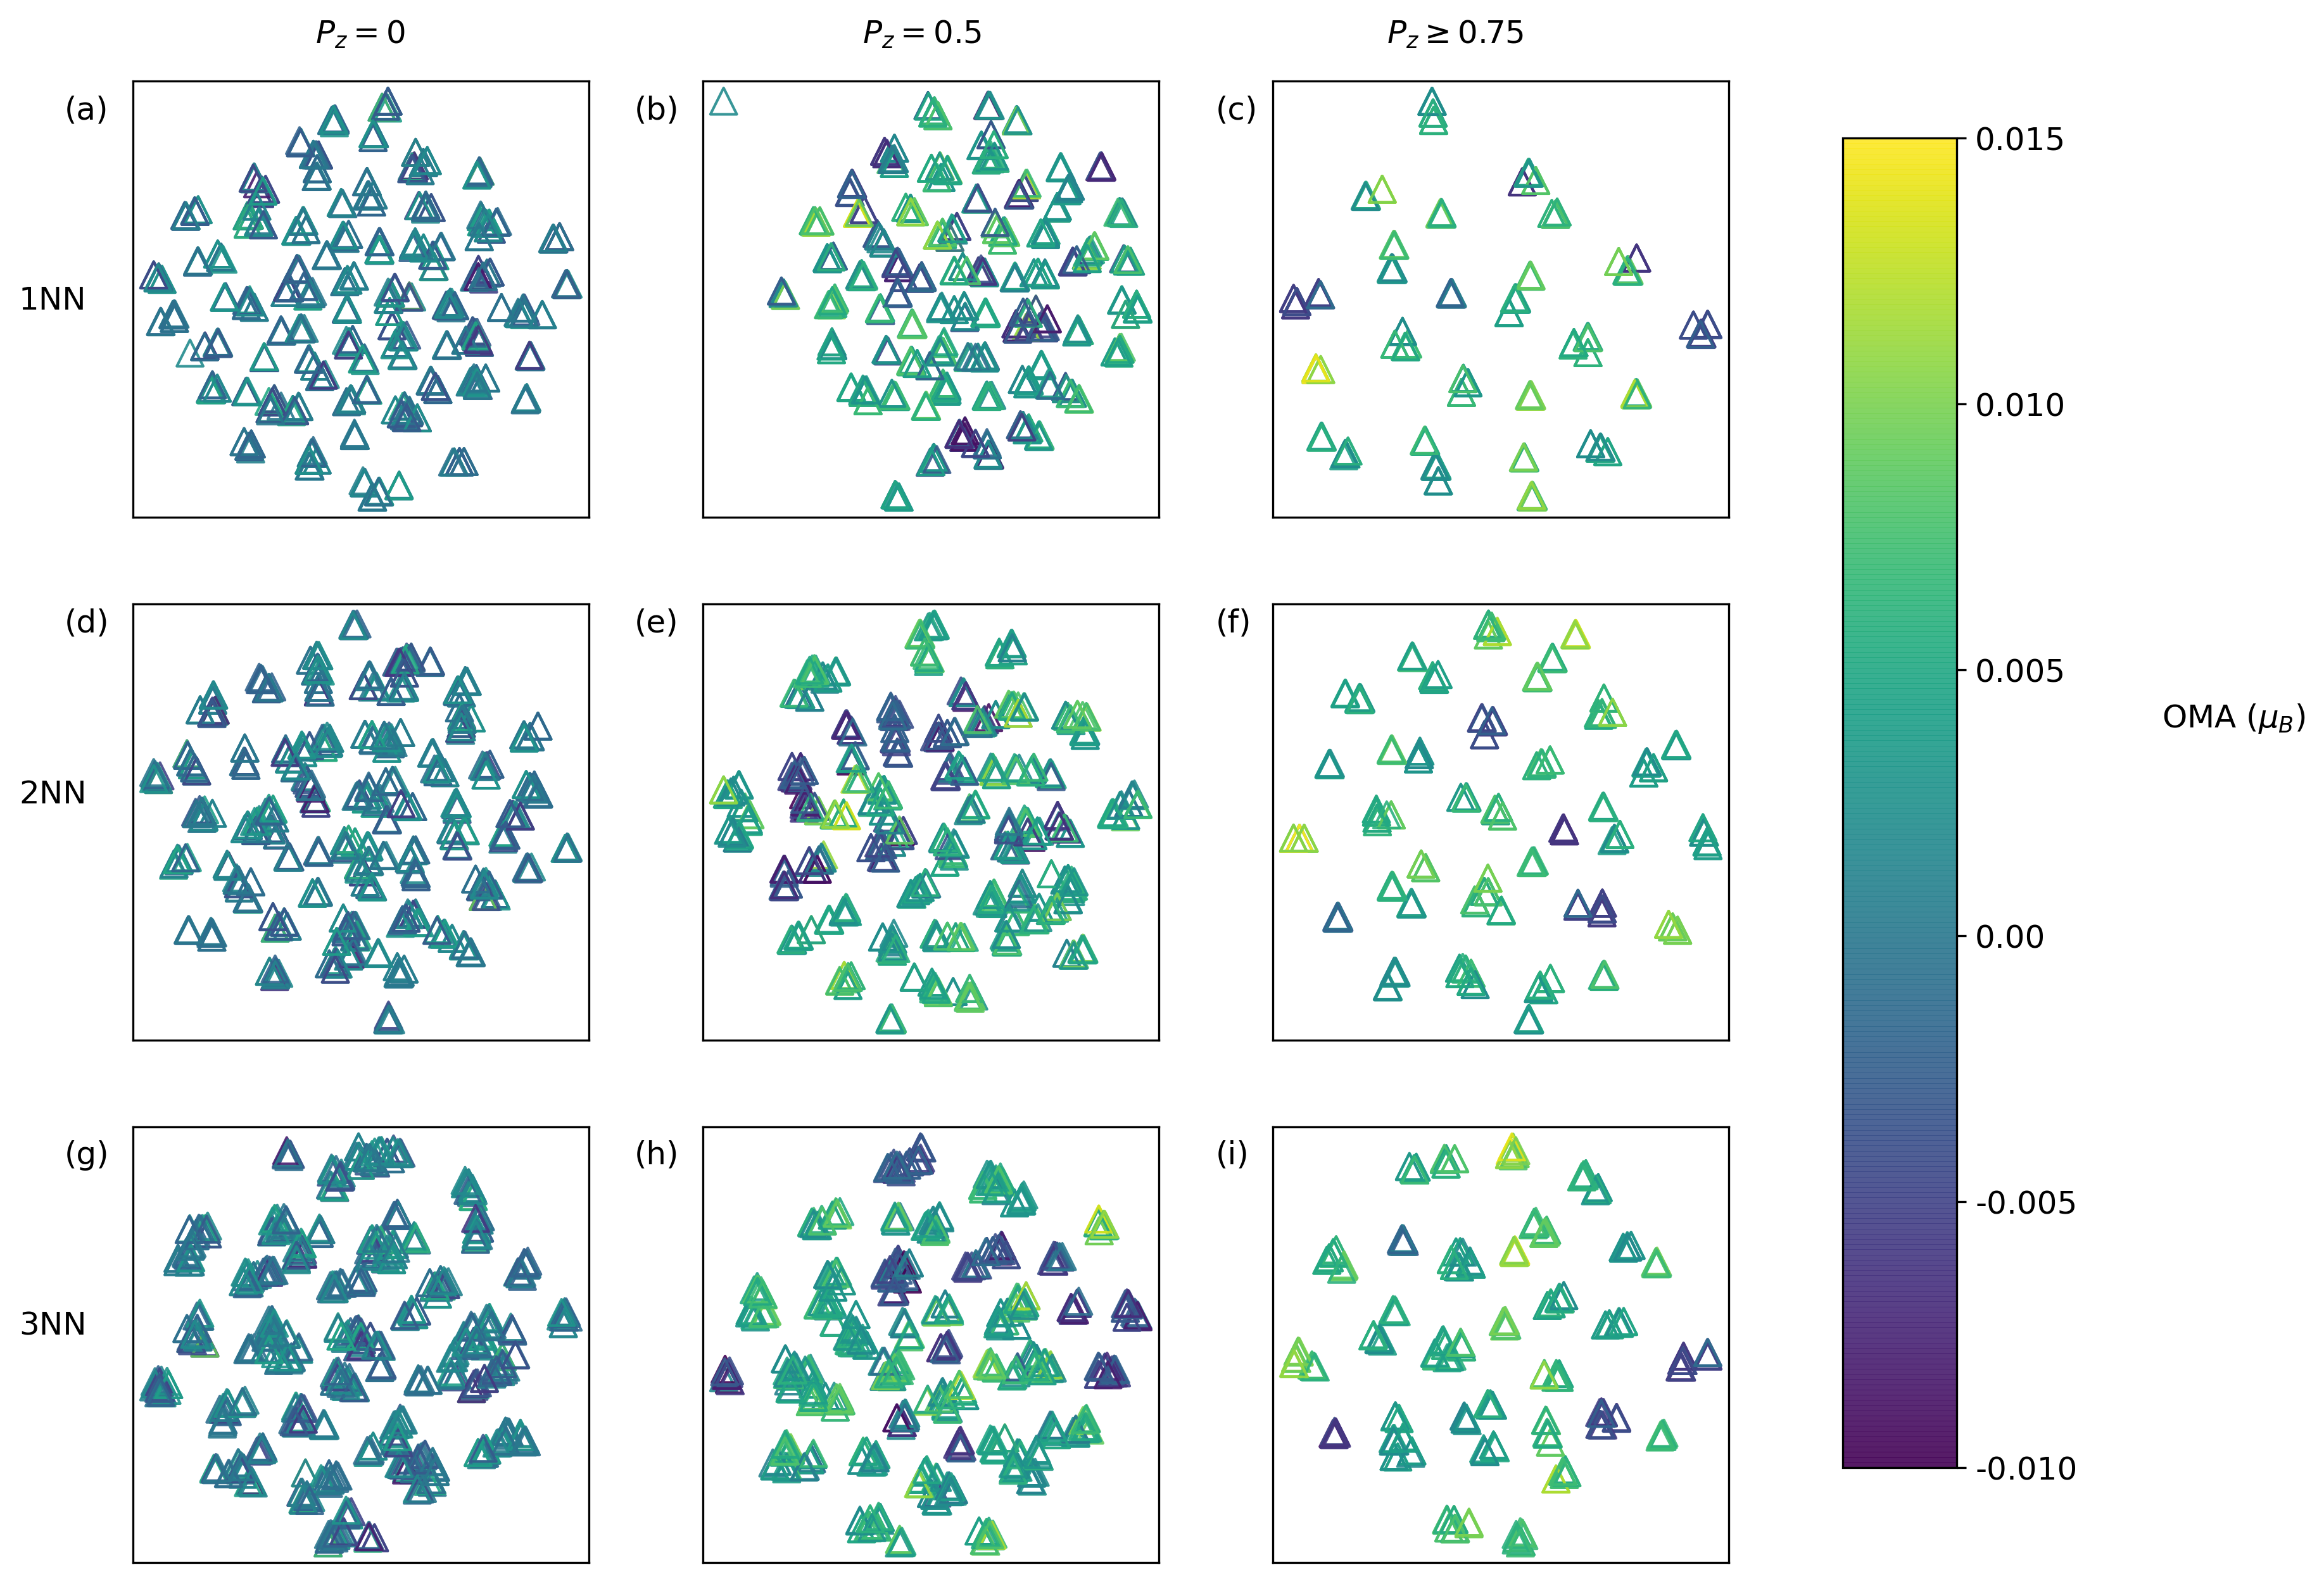

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 10),subplot_kw={'xticks': [], 'yticks': []})
# set the colormap

cmap = plt.cm.get_cmap('viridis')

# Uncomment to try different colormaps. Note: Make sure to use perceptually uniform sequential colormaps

#cmap = plt.cm.get_cmap('plasma_r')
#cmap = plt.cm.get_cmap('inferno')
#cmap = plt.cm.get_cmap('magma')



# set the marker

marker = '^'



# First nearest-neighbours

l1 = axs[0][2].scatter(X_t_sne_Pz_0p75_and_1_1NN[:,0:1], X_t_sne_Pz_0p75_and_1_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_1NN, vmax = 0.015, vmin = -0.01)
l2 = axs[0][1].scatter(X_t_sne_Pz_0p5_1NN[:,0:1], X_t_sne_Pz_0p5_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0p5_1NN, vmax = 0.015, vmin = -0.01)
l3 = axs[0][0].scatter(X_t_sne_Pz_0_1NN[:,0:1], X_t_sne_Pz_0_1NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_1NN, vmax = 0.015, vmin = -0.01)

l1.set_facecolor('none')
l2.set_facecolor('none')
l3.set_facecolor('none')


# Second nearest-neighbours

l4 = axs[1][2].scatter(X_t_sne_Pz_0p75_and_1_2NN[:,0:1], X_t_sne_Pz_0p75_and_1_2NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_2NN, vmax = 0.015, vmin = -0.01)
l5 = axs[1][1].scatter(X_t_sne_Pz_0p5_2NN[:,0:1], X_t_sne_Pz_0p5_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_2NN, vmax = 0.015, vmin = -0.01)
l6 = axs[1][0].scatter(X_t_sne_Pz_0_2NN[:,0:1], X_t_sne_Pz_0_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_2NN, vmax = 0.015, vmin = -0.01)


l4.set_facecolor('none')
l5.set_facecolor('none')
l6.set_facecolor('none')



# Third nearest-neighbours

l7 = axs[2][2].scatter(X_t_sne_Pz_0p75_and_1_3NN[:,0:1], X_t_sne_Pz_0p75_and_1_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_3NN, vmax = 0.015, vmin = -0.01)
l8 = axs[2][1].scatter(X_t_sne_Pz_0p5_3NN[:,0:1], X_t_sne_Pz_0p5_3NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_3NN, vmax = 0.015, vmin = -0.01)
l9 = axs[2][0].scatter(X_t_sne_Pz_0_3NN[:,0:1], X_t_sne_Pz_0_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0_3NN, vmax = 0.015, vmin = -0.01)

l7.set_facecolor('none')
l8.set_facecolor('none')
l9.set_facecolor('none')



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.88, 
                    wspace=0.25, 
                    hspace=0.2)

fig.text(0.65,0.9, r'$P_z \geq 0.75$',fontsize=12)
fig.text(0.42,0.9, r'$P_z = 0.5 $',fontsize=12)
fig.text(0.18,0.9, r'$P_z = 0$',fontsize=12)
fig.text(0.05,0.76, r'1NN',fontsize=12)
fig.text(0.05,0.50, r'2NN',fontsize=12)
fig.text(0.05,0.22, r'3NN',fontsize=12)

fig.text(0.07,0.86, r'(a)',fontsize=12)
fig.text(0.32,0.86, r'(b)',fontsize=12)
fig.text(0.575,0.86, r'(c)',fontsize=12)

fig.text(0.07,0.59, r'(d)',fontsize=12)
fig.text(0.32,0.59, r'(e)',fontsize=12)
fig.text(0.575,0.59, r'(f)',fontsize=12)

fig.text(0.07,0.31, r'(g)',fontsize=12)
fig.text(0.32,0.31, r'(h)',fontsize=12)
fig.text(0.575,0.31, r'(i)',fontsize=12)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
bar = fig.colorbar(l1, cax=cbar_ax, ticks=[-0.010, -0.005, 0.000, 0.005, 0.010, 0.015])

bar.ax.set_yticklabels(['-0.010','-0.005', '0.00', '0.005', '0.010', '0.015'], fontsize = 12)  # vertically oriented colorbar
fig.text(0.99,0.54, r'OMA ($\mu_{B}$)',fontsize=12)

plt.savefig("soap_tsne.png", dpi=300, bbox_inches='tight')
plt.show()

### Local atomic environments of Fe atoms in configurations with $P_z$ >= 0.75 (Fig. c)

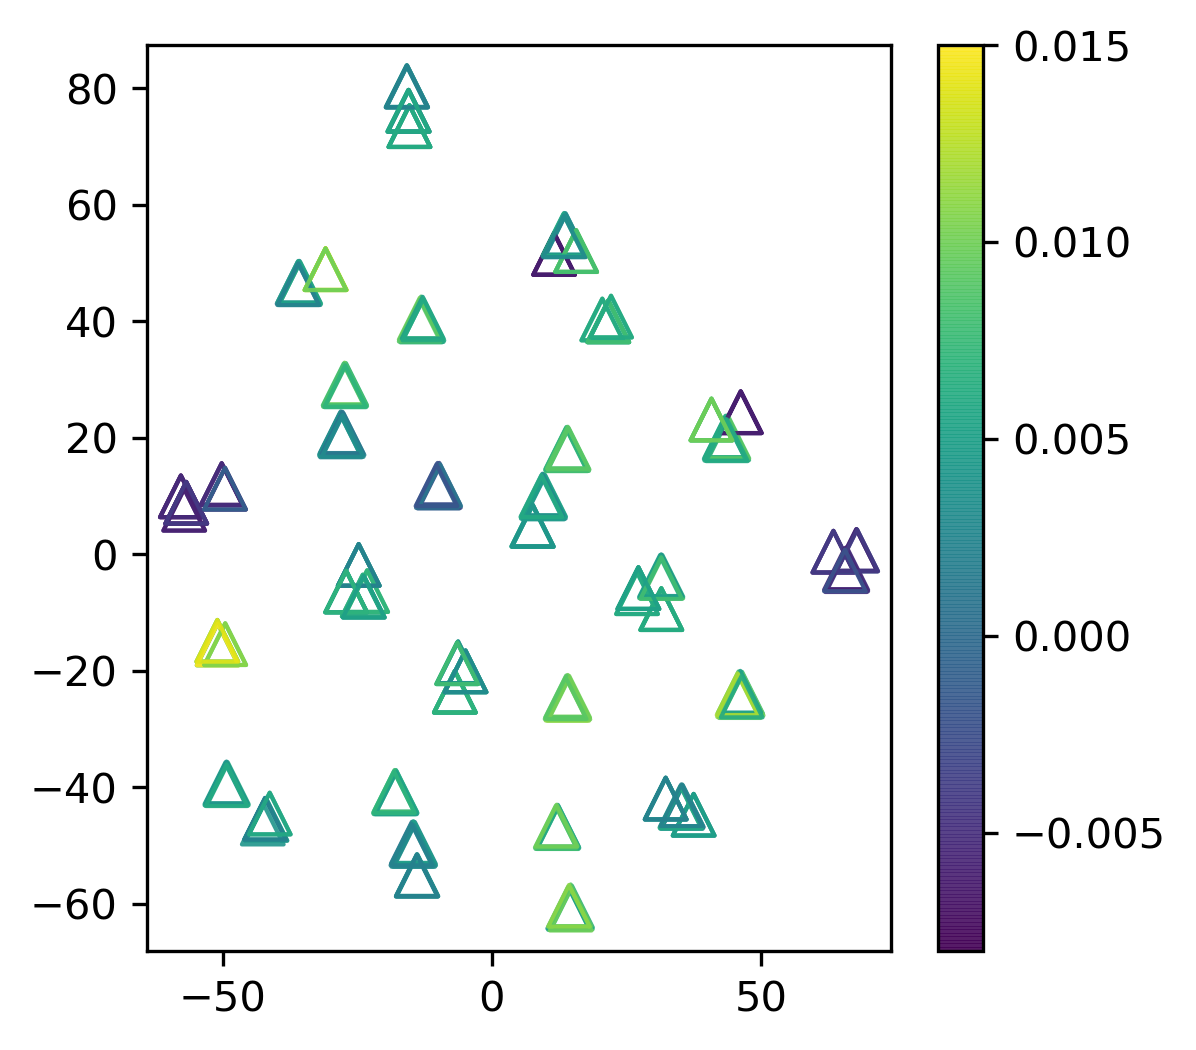

In [10]:
# Let's first get the plot for P_z >= 0.75 (Fig. c) 

fig, ax = plt.subplots(figsize=(4, 4))
g = ax.scatter(X_t_sne_Pz_0p75_and_1_1NN[:,0:1], X_t_sne_Pz_0p75_and_1_1NN[:,1:2], s=100, alpha=0.9, marker = '^', c = Y_last_two_1NN)
g.set_facecolor('none')
fig.colorbar(g)
# fig.savefig("soap_unfilled_0p75.png", dpi=300, bbox_inches='tight')

## Let's now trace back few of the local atomic environments resulting in high and low orbital moment anisotropy. 

#### Following illustration was made using inkscape and VESTA

![](soap_tsne_fig_c_high_dpi.png)

# Effect of perplexity

## perplexity = 10

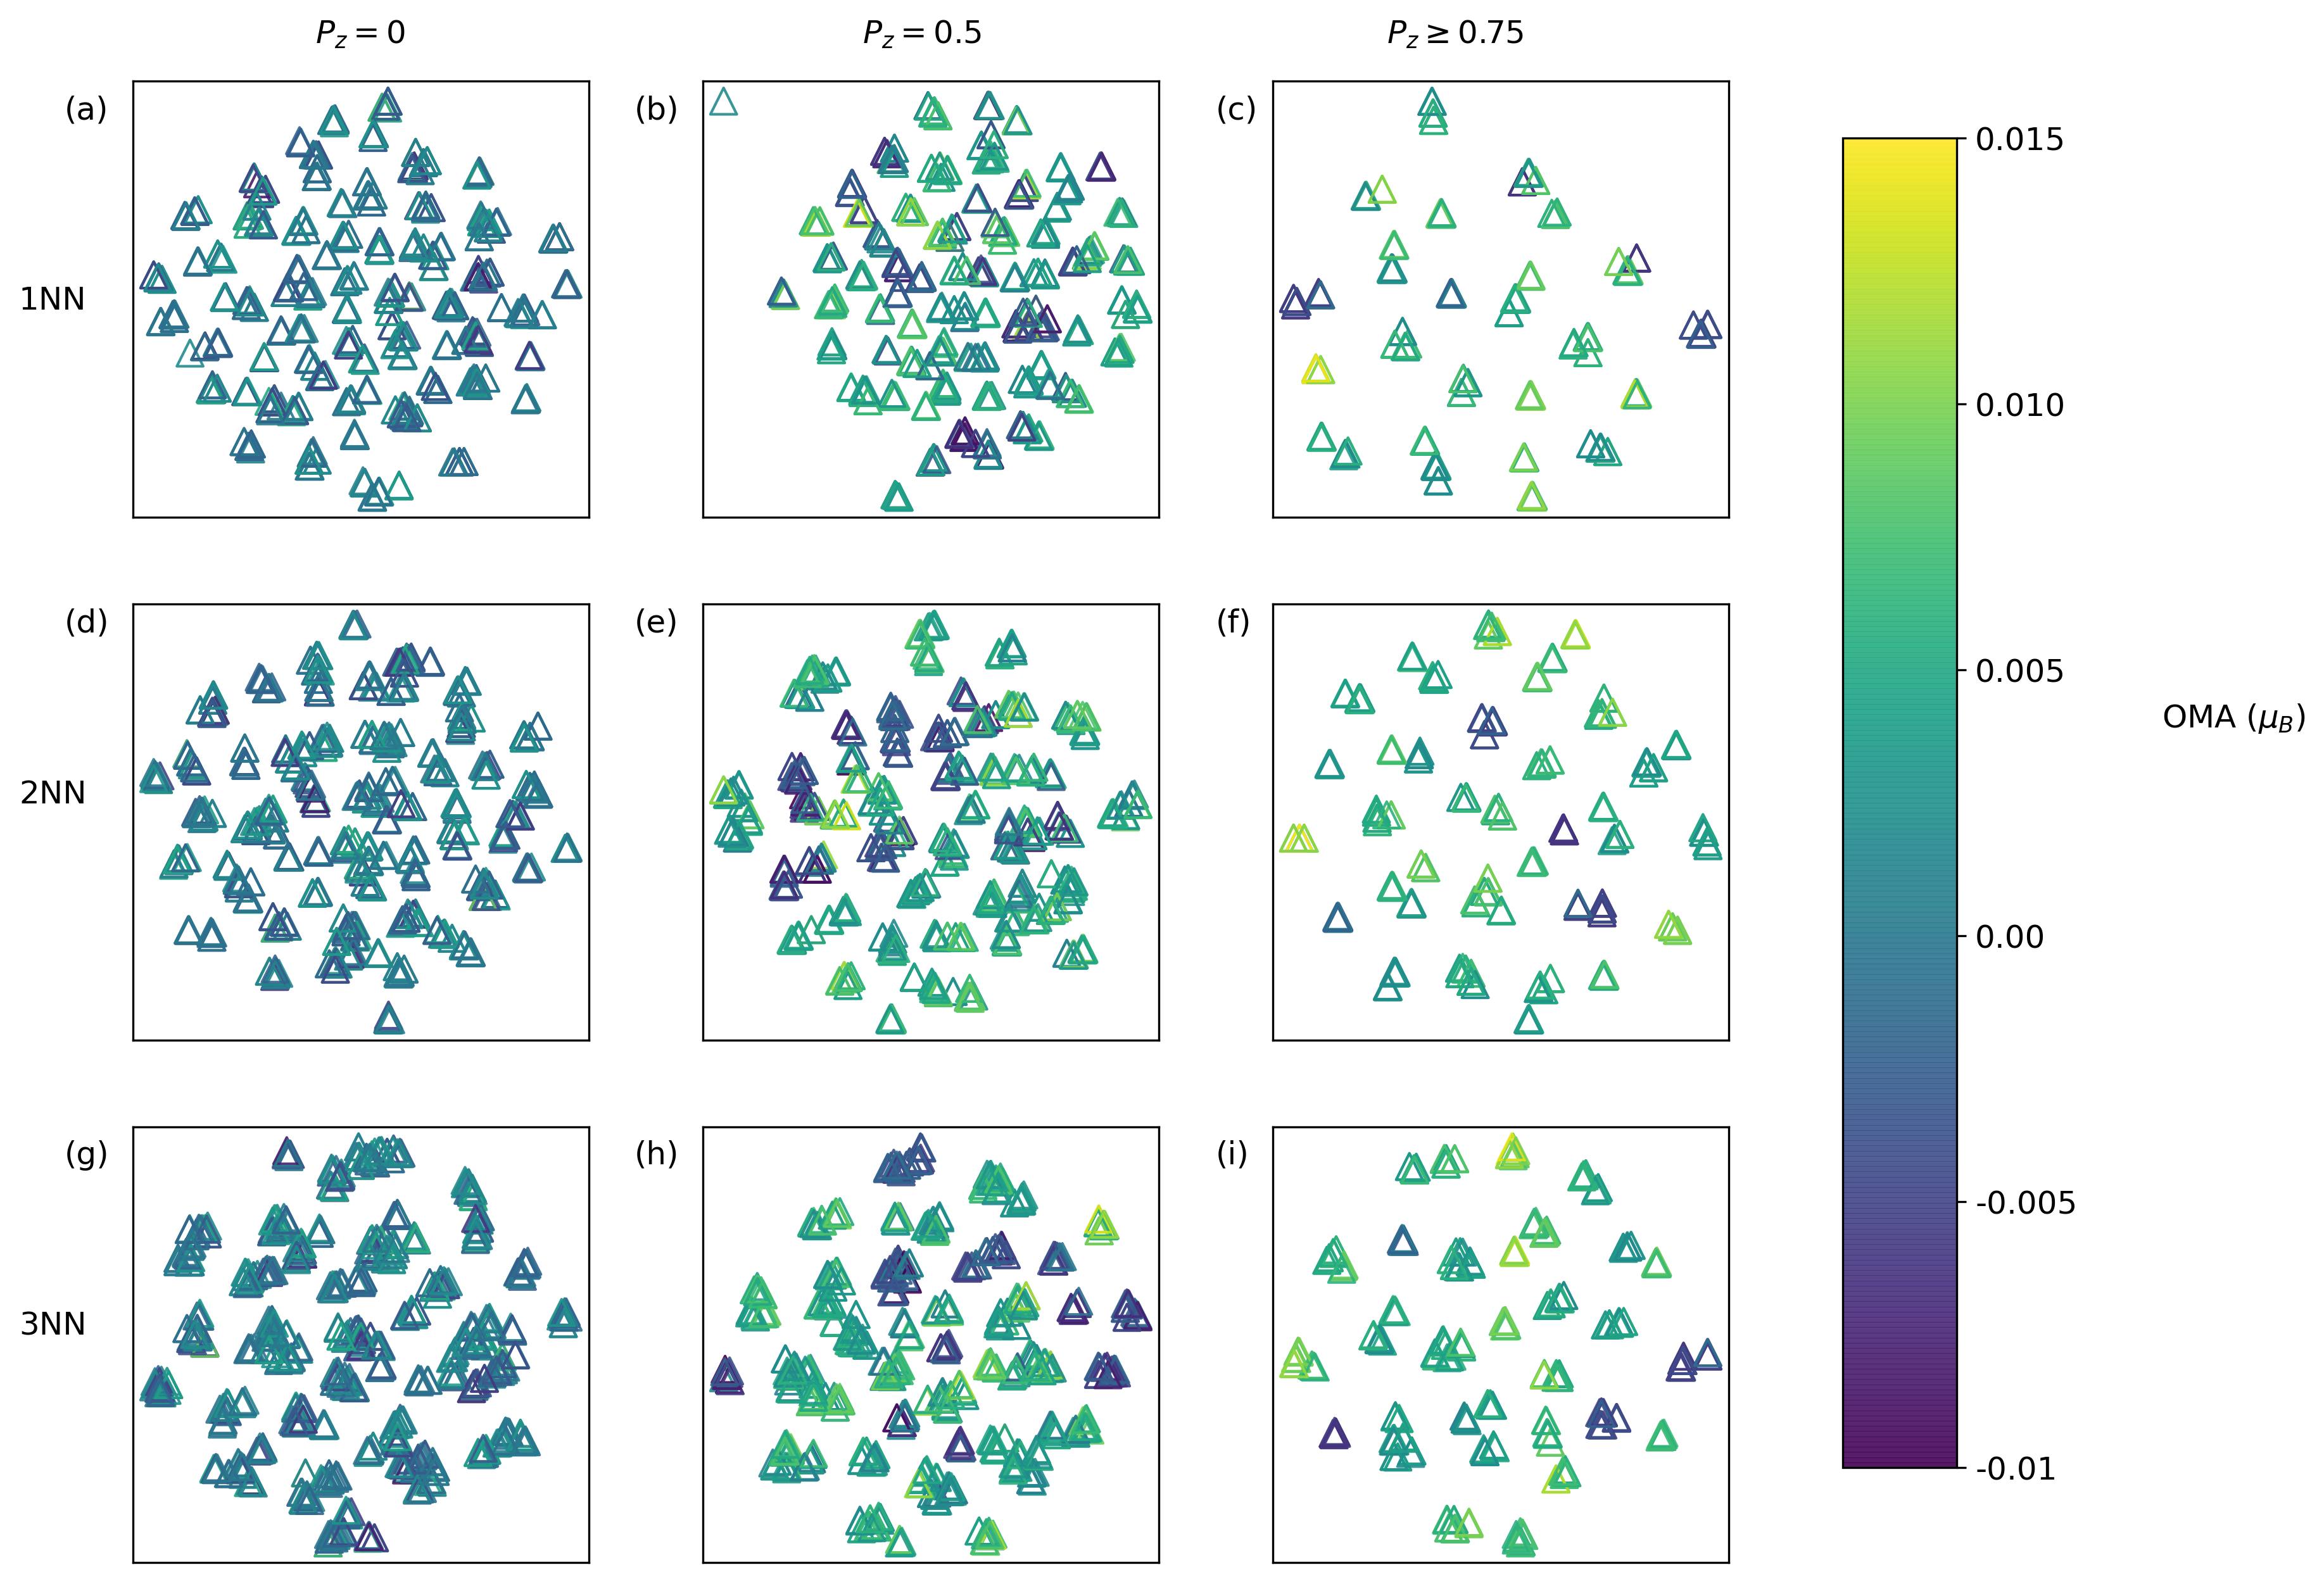

In [11]:
# Set perplexity = 10

per = 10

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 10),subplot_kw={'xticks': [], 'yticks': []})
# set the colormap

cmap = plt.cm.get_cmap('viridis')

# Uncomment to try different colormaps. Note: Make sure to use perceptually uniform sequential colormaps

#cmap = plt.cm.get_cmap('plasma_r')
#cmap = plt.cm.get_cmap('inferno')
#cmap = plt.cm.get_cmap('magma')



# set the marker

marker = '^'



# First nearest-neighbours

l1 = axs[0][2].scatter(X_t_sne_Pz_0p75_and_1_1NN[:,0:1], X_t_sne_Pz_0p75_and_1_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_1NN, vmax = 0.015, vmin = -0.01)
l2 = axs[0][1].scatter(X_t_sne_Pz_0p5_1NN[:,0:1], X_t_sne_Pz_0p5_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0p5_1NN, vmax = 0.015, vmin = -0.01)
l3 = axs[0][0].scatter(X_t_sne_Pz_0_1NN[:,0:1], X_t_sne_Pz_0_1NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_1NN, vmax = 0.015, vmin = -0.01)

l1.set_facecolor('none')
l2.set_facecolor('none')
l3.set_facecolor('none')


# Second nearest-neighbours

l4 = axs[1][2].scatter(X_t_sne_Pz_0p75_and_1_2NN[:,0:1], X_t_sne_Pz_0p75_and_1_2NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_2NN, vmax = 0.015, vmin = -0.01)
l5 = axs[1][1].scatter(X_t_sne_Pz_0p5_2NN[:,0:1], X_t_sne_Pz_0p5_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_2NN, vmax = 0.015, vmin = -0.01)
l6 = axs[1][0].scatter(X_t_sne_Pz_0_2NN[:,0:1], X_t_sne_Pz_0_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_2NN, vmax = 0.015, vmin = -0.01)


l4.set_facecolor('none')
l5.set_facecolor('none')
l6.set_facecolor('none')



# Third nearest-neighbours

l7 = axs[2][2].scatter(X_t_sne_Pz_0p75_and_1_3NN[:,0:1], X_t_sne_Pz_0p75_and_1_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_3NN, vmax = 0.015, vmin = -0.01)
l8 = axs[2][1].scatter(X_t_sne_Pz_0p5_3NN[:,0:1], X_t_sne_Pz_0p5_3NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_3NN, vmax = 0.015, vmin = -0.01)
l9 = axs[2][0].scatter(X_t_sne_Pz_0_3NN[:,0:1], X_t_sne_Pz_0_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0_3NN, vmax = 0.015, vmin = -0.01)

l7.set_facecolor('none')
l8.set_facecolor('none')
l9.set_facecolor('none')



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.88, 
                    wspace=0.25, 
                    hspace=0.2)

fig.text(0.65,0.9, r'$P_z \geq 0.75$',fontsize=12)
fig.text(0.42,0.9, r'$P_z = 0.5 $',fontsize=12)
fig.text(0.18,0.9, r'$P_z = 0$',fontsize=12)
fig.text(0.05,0.76, r'1NN',fontsize=12)
fig.text(0.05,0.50, r'2NN',fontsize=12)
fig.text(0.05,0.22, r'3NN',fontsize=12)

fig.text(0.07,0.86, r'(a)',fontsize=12)
fig.text(0.32,0.86, r'(b)',fontsize=12)
fig.text(0.575,0.86, r'(c)',fontsize=12)

fig.text(0.07,0.59, r'(d)',fontsize=12)
fig.text(0.32,0.59, r'(e)',fontsize=12)
fig.text(0.575,0.59, r'(f)',fontsize=12)

fig.text(0.07,0.31, r'(g)',fontsize=12)
fig.text(0.32,0.31, r'(h)',fontsize=12)
fig.text(0.575,0.31, r'(i)',fontsize=12)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
bar = fig.colorbar(l1, cax=cbar_ax, ticks=[-0.01, -0.005, 0.000, 0.005, 0.010, 0.015])

bar.ax.set_yticklabels(['-0.01','-0.005', '0.00', '0.005', '0.010', '0.015'], fontsize = 12)  # vertically oriented colorbar
fig.text(0.99,0.54, r'OMA ($\mu_{B}$)',fontsize=12)

#plt.savefig("soap_10_unfilled.png", dpi=300, bbox_inches='tight')
plt.show()

## perplexity = 20

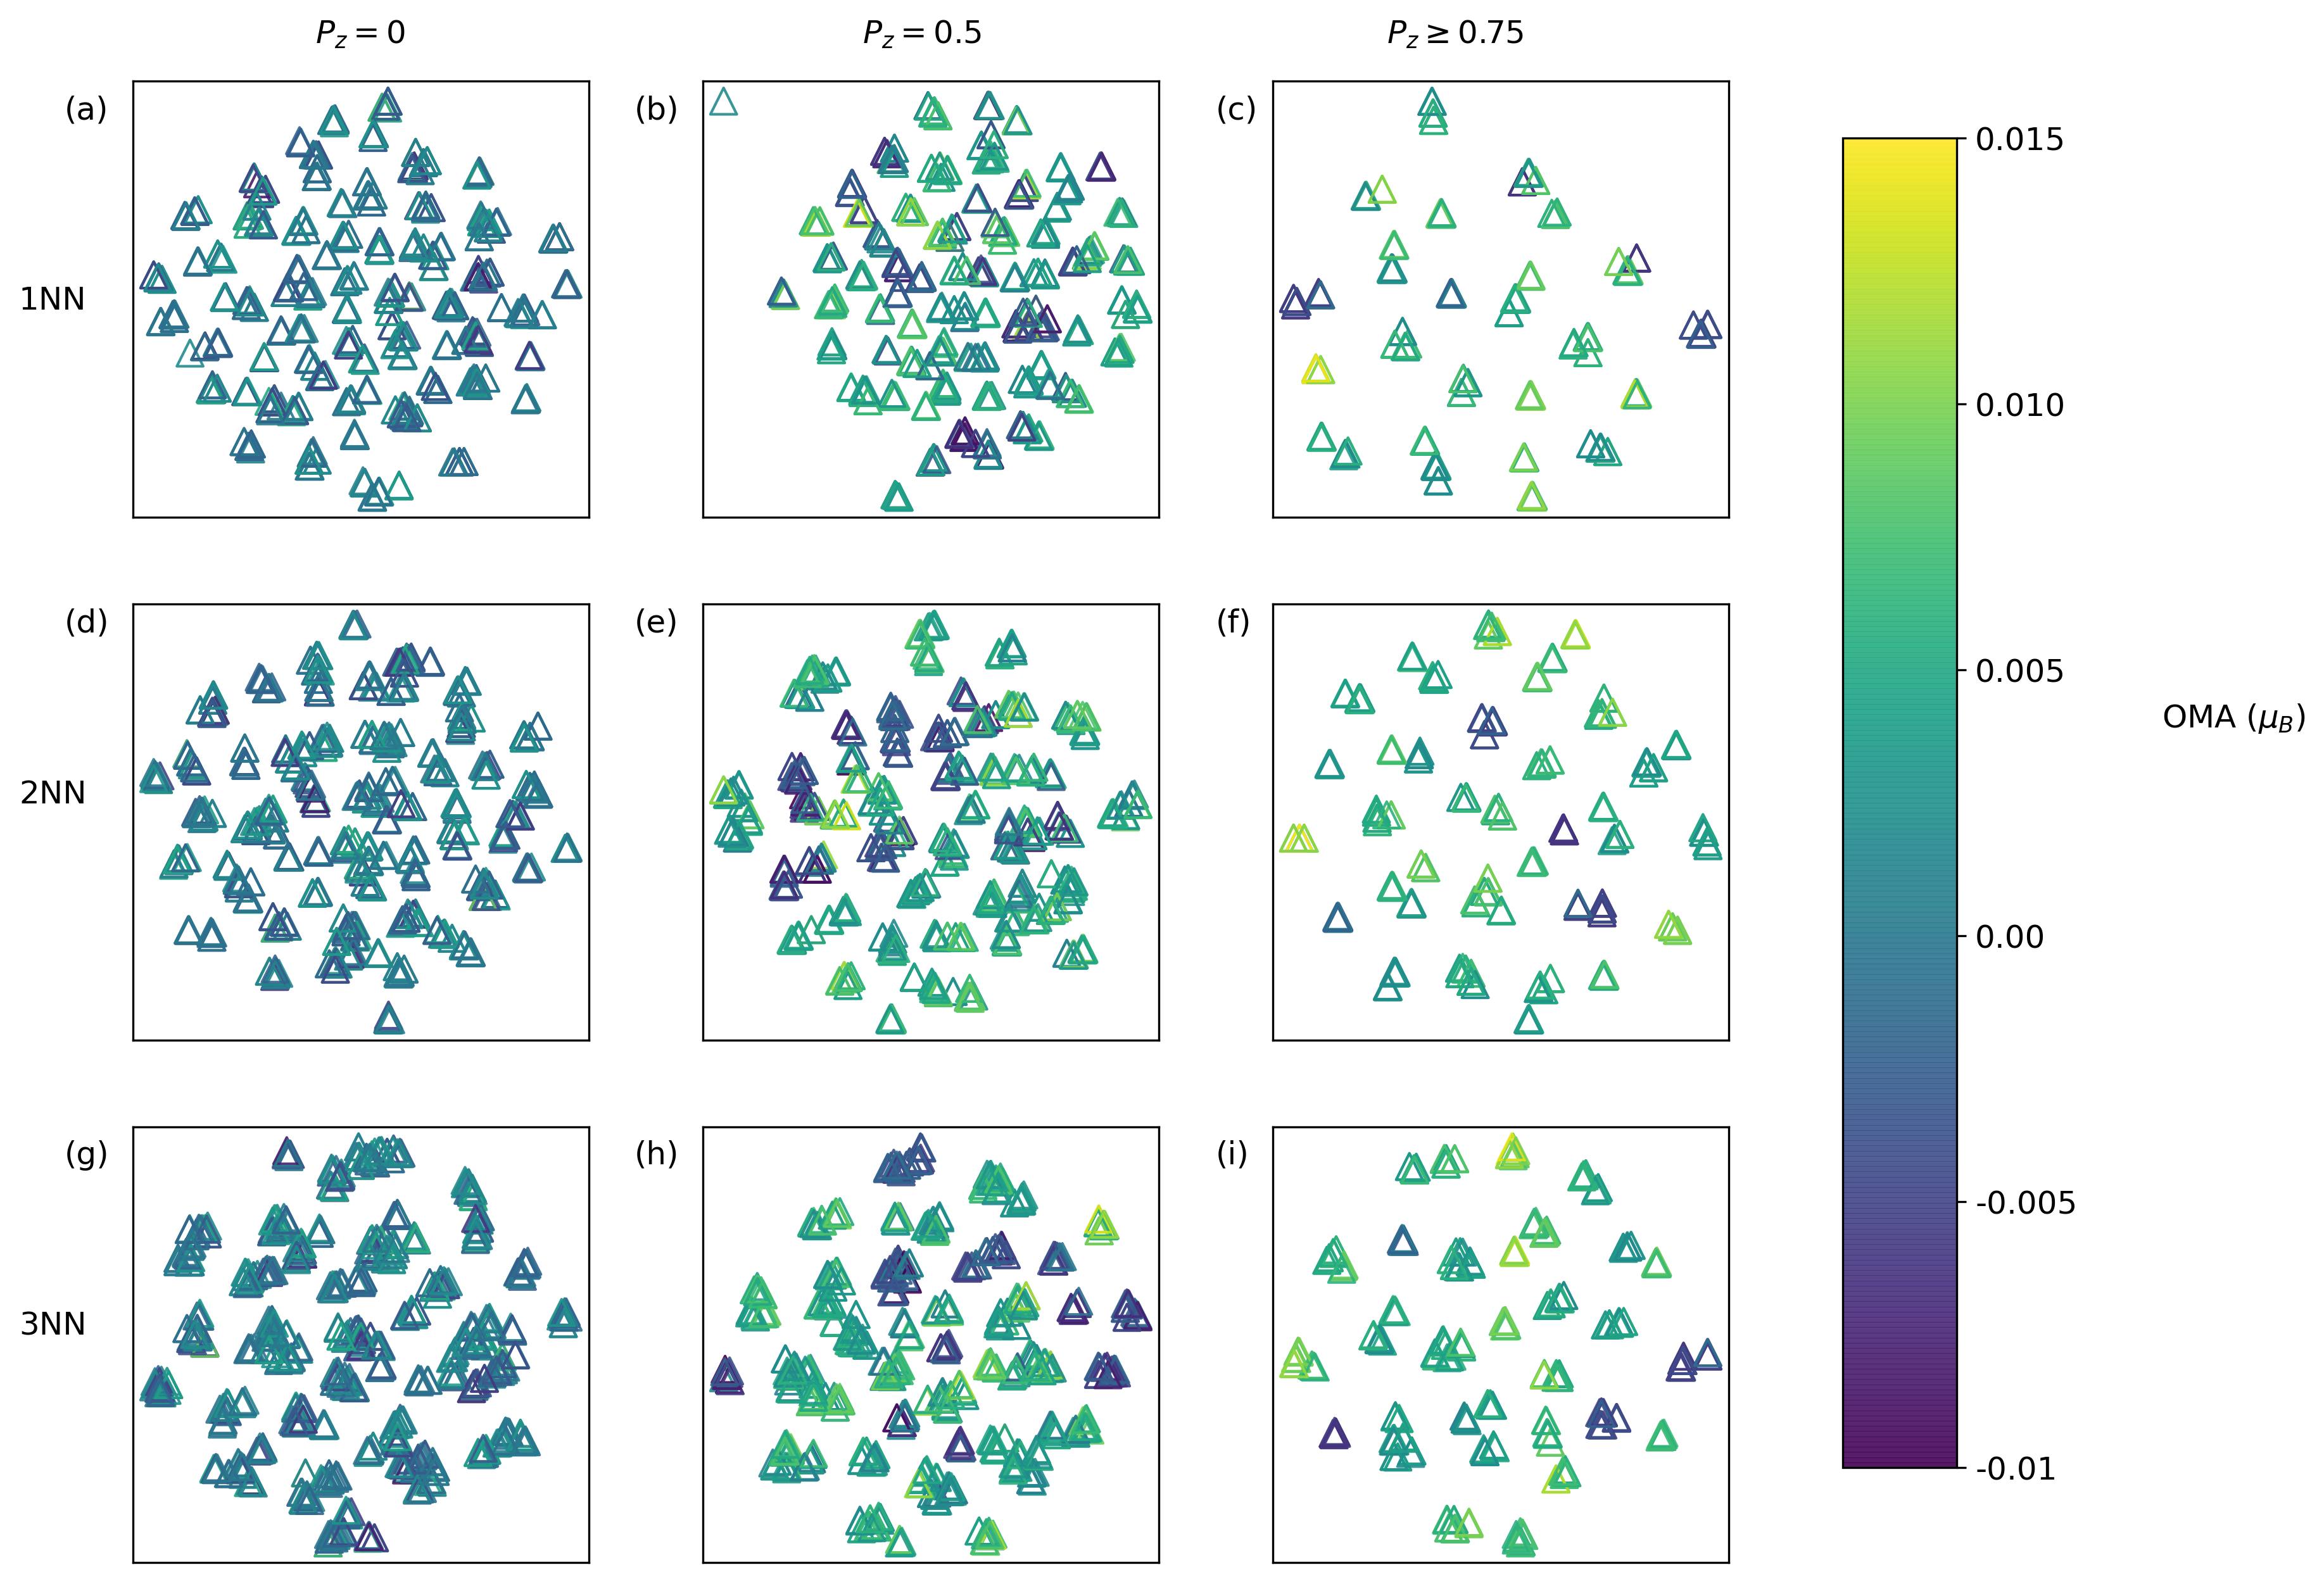

In [12]:
# Set perplexity = 20

per = 20
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 10),subplot_kw={'xticks': [], 'yticks': []})
# set the colormap

cmap = plt.cm.get_cmap('viridis')

# Uncomment to try different colormaps. Note: Make sure to use perceptually uniform sequential colormaps

#cmap = plt.cm.get_cmap('plasma_r')
#cmap = plt.cm.get_cmap('inferno')
#cmap = plt.cm.get_cmap('magma')



# set the marker

marker = '^'



# First nearest-neighbours

l1 = axs[0][2].scatter(X_t_sne_Pz_0p75_and_1_1NN[:,0:1], X_t_sne_Pz_0p75_and_1_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_1NN, vmax = 0.015, vmin = -0.01)
l2 = axs[0][1].scatter(X_t_sne_Pz_0p5_1NN[:,0:1], X_t_sne_Pz_0p5_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0p5_1NN, vmax = 0.015, vmin = -0.01)
l3 = axs[0][0].scatter(X_t_sne_Pz_0_1NN[:,0:1], X_t_sne_Pz_0_1NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_1NN, vmax = 0.015, vmin = -0.01)

l1.set_facecolor('none')
l2.set_facecolor('none')
l3.set_facecolor('none')


# Second nearest-neighbours

l4 = axs[1][2].scatter(X_t_sne_Pz_0p75_and_1_2NN[:,0:1], X_t_sne_Pz_0p75_and_1_2NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_2NN, vmax = 0.015, vmin = -0.01)
l5 = axs[1][1].scatter(X_t_sne_Pz_0p5_2NN[:,0:1], X_t_sne_Pz_0p5_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_2NN, vmax = 0.015, vmin = -0.01)
l6 = axs[1][0].scatter(X_t_sne_Pz_0_2NN[:,0:1], X_t_sne_Pz_0_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_2NN, vmax = 0.015, vmin = -0.01)


l4.set_facecolor('none')
l5.set_facecolor('none')
l6.set_facecolor('none')



# Third nearest-neighbours

l7 = axs[2][2].scatter(X_t_sne_Pz_0p75_and_1_3NN[:,0:1], X_t_sne_Pz_0p75_and_1_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_3NN, vmax = 0.015, vmin = -0.01)
l8 = axs[2][1].scatter(X_t_sne_Pz_0p5_3NN[:,0:1], X_t_sne_Pz_0p5_3NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_3NN, vmax = 0.015, vmin = -0.01)
l9 = axs[2][0].scatter(X_t_sne_Pz_0_3NN[:,0:1], X_t_sne_Pz_0_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0_3NN, vmax = 0.015, vmin = -0.01)

l7.set_facecolor('none')
l8.set_facecolor('none')
l9.set_facecolor('none')



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.88, 
                    wspace=0.25, 
                    hspace=0.2)

fig.text(0.65,0.9, r'$P_z \geq 0.75$',fontsize=12)
fig.text(0.42,0.9, r'$P_z = 0.5 $',fontsize=12)
fig.text(0.18,0.9, r'$P_z = 0$',fontsize=12)
fig.text(0.05,0.76, r'1NN',fontsize=12)
fig.text(0.05,0.50, r'2NN',fontsize=12)
fig.text(0.05,0.22, r'3NN',fontsize=12)

fig.text(0.07,0.86, r'(a)',fontsize=12)
fig.text(0.32,0.86, r'(b)',fontsize=12)
fig.text(0.575,0.86, r'(c)',fontsize=12)

fig.text(0.07,0.59, r'(d)',fontsize=12)
fig.text(0.32,0.59, r'(e)',fontsize=12)
fig.text(0.575,0.59, r'(f)',fontsize=12)

fig.text(0.07,0.31, r'(g)',fontsize=12)
fig.text(0.32,0.31, r'(h)',fontsize=12)
fig.text(0.575,0.31, r'(i)',fontsize=12)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
bar = fig.colorbar(l1, cax=cbar_ax, ticks=[-0.01, -0.005, 0.000, 0.005, 0.010, 0.015])

bar.ax.set_yticklabels(['-0.01','-0.005', '0.00', '0.005', '0.010', '0.015'], fontsize = 12)  # vertically oriented colorbar
fig.text(0.99,0.54, r'OMA ($\mu_{B}$)',fontsize=12)

#plt.savefig("soap_10_unfilled.png", dpi=300, bbox_inches='tight')
plt.show()

## 2. PCA

In [13]:
def get_pca_X(X):
    
    pca = decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    return X_pca

### Get PCA reduced SOAP vectors for 1NN, 2NN, and 3NN

In [14]:
# First Nearest Neighbours

X_pca_Pz_0_1NN = get_pca_X(X_0_1NN)
X_pca_Pz_0p25_1NN  = get_pca_X(X_0p25_1NN)
X_pca_Pz_0p5_1NN = get_pca_X(X_0p5_1NN)
X_pca_Pz_0p75_and_1_1NN = get_pca_X(X_last_two_1NN)

# (Second Nearest Neighbours

X_pca_Pz_0_2NN = get_pca_X(X_0_2NN)
X_pca_Pz_0p25_2NN  = get_pca_X(X_0p25_2NN)
X_pca_Pz_0p5_2NN = get_pca_X(X_0p5_2NN)
X_pca_Pz_0p75_and_1_2NN = get_pca_X(X_last_two_2NN)

# Third Nearest Neighbours)

X_pca_Pz_0_3NN = get_pca_X(X_0_3NN)
X_pca_Pz_0p25_3NN  = get_pca_X(X_0p25_3NN)
X_pca_Pz_0p5_3NN = get_pca_X(X_0p5_3NN)
X_pca_Pz_0p75_and_1_3NN = get_pca_X(X_last_two_3NN)

### Plot the PCA components 1 and 2 of SOAP vectors

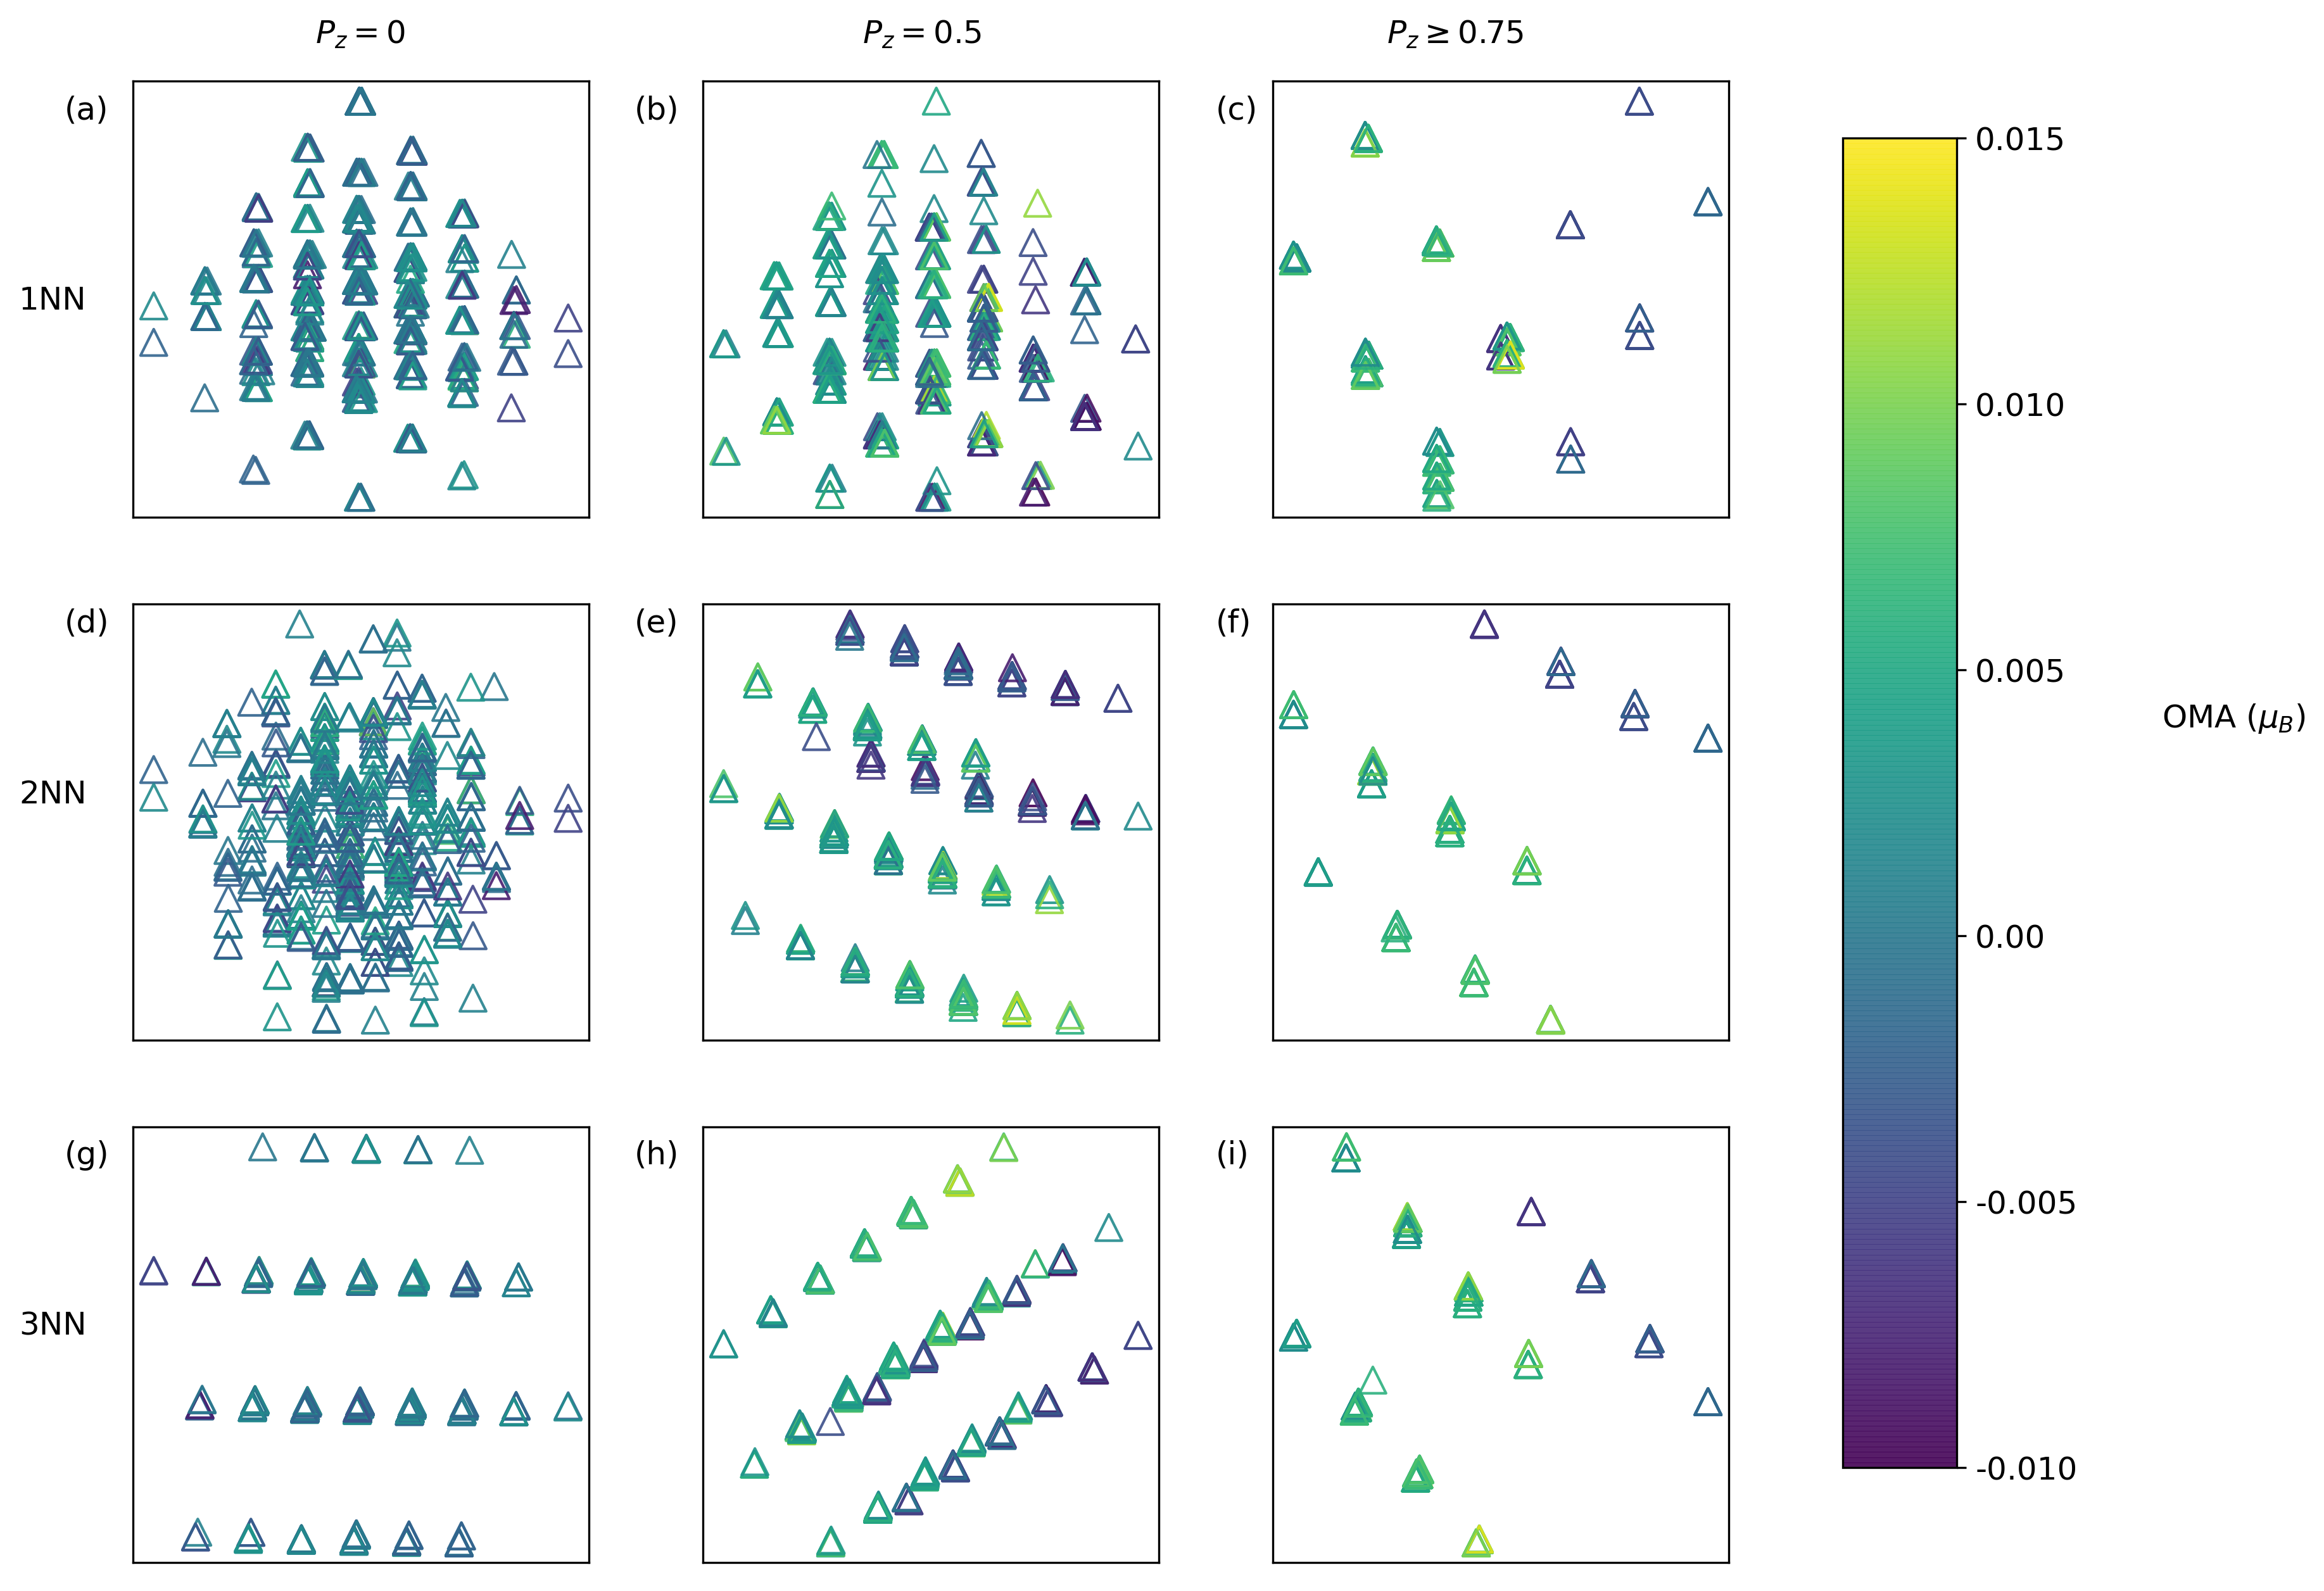

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 10),subplot_kw={'xticks': [], 'yticks': []})
# set the colormap

cmap = plt.cm.get_cmap('viridis')

# Uncomment to try different colormaps. Note: Make sure to use perceptually uniform sequential colormaps

#cmap = plt.cm.get_cmap('plasma_r')
#cmap = plt.cm.get_cmap('inferno')
#cmap = plt.cm.get_cmap('magma')



# set the marker

marker = '^'



# First nearest-neighbours

l1 = axs[0][2].scatter(X_pca_Pz_0p75_and_1_1NN[:,0:1], X_pca_Pz_0p75_and_1_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_1NN, vmax = 0.015, vmin = -0.01)
l2 = axs[0][1].scatter(X_pca_Pz_0p5_1NN[:,0:1], X_pca_Pz_0p5_1NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0p5_1NN, vmax = 0.015, vmin = -0.01)
l3 = axs[0][0].scatter(X_pca_Pz_0_1NN[:,0:1], X_pca_Pz_0_1NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_1NN, vmax = 0.015, vmin = -0.01)

l1.set_facecolor('none')
l2.set_facecolor('none')
l3.set_facecolor('none')


# Second nearest-neighbours

l4 = axs[1][2].scatter(X_pca_Pz_0p75_and_1_2NN[:,0:1], X_pca_Pz_0p75_and_1_2NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_2NN, vmax = 0.015, vmin = -0.01)
l5 = axs[1][1].scatter(X_pca_Pz_0p5_2NN[:,0:1], X_pca_Pz_0p5_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_2NN, vmax = 0.015, vmin = -0.01)
l6 = axs[1][0].scatter(X_pca_Pz_0_2NN[:,0:1], X_pca_Pz_0_2NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0_2NN, vmax = 0.015, vmin = -0.01)


l4.set_facecolor('none')
l5.set_facecolor('none')
l6.set_facecolor('none')



# Third nearest-neighbours

l7 = axs[2][2].scatter(X_pca_Pz_0p75_and_1_3NN[:,0:1], X_pca_Pz_0p75_and_1_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_last_two_3NN, vmax = 0.015, vmin = -0.01)
l8 = axs[2][1].scatter(X_pca_Pz_0p5_3NN[:,0:1], X_pca_Pz_0p5_3NN[:,1:2],  s=100, alpha=0.9, marker = marker, c = Y_0p5_3NN, vmax = 0.015, vmin = -0.01)
l9 = axs[2][0].scatter(X_pca_Pz_0_3NN[:,0:1], X_pca_Pz_0_3NN[:,1:2], s=100, alpha=0.9, marker = marker, c = Y_0_3NN, vmax = 0.015, vmin = -0.01)

l7.set_facecolor('none')
l8.set_facecolor('none')
l9.set_facecolor('none')



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.88, 
                    wspace=0.25, 
                    hspace=0.2)

fig.text(0.65,0.9, r'$P_z \geq 0.75$',fontsize=12)
fig.text(0.42,0.9, r'$P_z = 0.5 $',fontsize=12)
fig.text(0.18,0.9, r'$P_z = 0$',fontsize=12)
fig.text(0.05,0.76, r'1NN',fontsize=12)
fig.text(0.05,0.50, r'2NN',fontsize=12)
fig.text(0.05,0.22, r'3NN',fontsize=12)

fig.text(0.07,0.86, r'(a)',fontsize=12)
fig.text(0.32,0.86, r'(b)',fontsize=12)
fig.text(0.575,0.86, r'(c)',fontsize=12)

fig.text(0.07,0.59, r'(d)',fontsize=12)
fig.text(0.32,0.59, r'(e)',fontsize=12)
fig.text(0.575,0.59, r'(f)',fontsize=12)

fig.text(0.07,0.31, r'(g)',fontsize=12)
fig.text(0.32,0.31, r'(h)',fontsize=12)
fig.text(0.575,0.31, r'(i)',fontsize=12)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
bar = fig.colorbar(l1, cax=cbar_ax, ticks=[-0.010, -0.005, 0.000, 0.005, 0.010, 0.015])

bar.ax.set_yticklabels(['-0.010','-0.005', '0.00', '0.005', '0.010', '0.015'], fontsize = 12)  # vertically oriented colorbar
fig.text(0.99,0.54, r'OMA ($\mu_{B}$)',fontsize=12)

#plt.savefig("soap_pca.png", dpi=300, bbox_inches='tight')
plt.show()